# Tail analysis

In [1]:
import pickle
import analysis_utils
import plot_utils
from collections import defaultdict, OrderedDict
import math
from scipy.stats import pearsonr, spearmanr
import numpy as np
from scipy.stats import kendalltau
import pandas as pd
from scipy.stats import entropy
from copy import deepcopy

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


sns.set_style("whitegrid")

In [3]:
debug=False

### 1) Load data from BIN files

In [4]:
#wes_title='wes2015'
n3_title='n3'
aida_title='aida'
#rss_title='rss500'
#reuters_title='reuters128'
titles=[aida_title, n3_title]# rss_title, reuters_title]#, wes_title]
systems=['agdistis', 'spotlight', 'wat']

In [5]:
### Load data from disk
system_data_articles={}
for system in systems:
    system_data_articles[system]={}
    for data_title in titles:
        with open('bin/%s_%s.bin' % (data_title, system), 'rb') as outfile:
            system_data_articles[system][data_title]=pickle.load(outfile)

#### [DEBUG-only] Store agdistis output to a file

In [6]:
if debug:
    with open('debug/agdmag_aida_debug.tsv', 'w') as w:
        w.write('collection\tarticle_ID\tbegin_index\tend_index\tmention\tgold_link\tsystem_link\n')
        for article in aida_agd_articles:
            for mention in article.entity_mentions:
                if mention.sys_link.startswith('http://aksw.org/'):
                    mention.sys_link = '--NME--'

                a_row=[article.collection, str(article.identifier), 
                       str(mention.begin_index), str(mention.end_index), 
                       mention.mention, mention.gold_link, 
                       mention.sys_link]
                w.write('\t'.join(a_row) + '\n')

**1.1. Pick dataset**

In [7]:
system_articles = {}

for system in systems:
    system_articles[system]=set()
    for data_title in titles: 
        system_articles[system] |= system_data_articles[system][data_title]

**1.2. Normalize AGDISTIS NILs given as custom AKSW URIs **

In [8]:
for article in system_articles['agdistis']:
    for mention in article.entity_mentions:
        if mention.sys_link.startswith('http://aksw.org/'):
            mention.sys_link = '--NME--'


**1.3.Normalize forms to lower-case (disabled for now)**

In [9]:
if debug:
    for system in systems:
        for article in system_articles[system]:
            for mention in article.entity_mentions:
                mention.mention=mention.mention.lower()
                print(mention.mention)

### 2) Performance

<span style="background-color:lightgreen">Section 6.1. of the paper</span>

#### 2.1. Overall

In [36]:
def overall_performance_macro_prf(articles, skip_nils=True, skip_nonnils=False):
    """
    Compute overall macro precision, recall and F1 of a system.
    """
    tp=defaultdict(int)
    fn=defaultdict(int)
    fp=defaultdict(int)
    all_tuples=set()
    for article in articles:
            for entity in article.entity_mentions:
                    if skip_nils and entity.gold_link=='--NME--':
                            continue
                    if skip_nonnils and entity.gold_link!='--NME--':
                            continue
                    gold_tuple = (entity.mention, entity.gold_link)
                    sys_tuple = (entity.mention, entity.sys_link)
                    all_tuples.add(gold_tuple)
                    all_tuples.add(sys_tuple)
                    if entity.gold_link==entity.sys_link:
                            tp[gold_tuple]+=1
                    else:
                            if entity.sys_link!='--NME--':
                                    fp[sys_tuple]+=1
                            if entity.gold_link!='--NME--':
                                    fn[gold_tuple]+=1
    p={}
    r={}
    f1={}
    for t in all_tuples:
        if tp[t]+fp[t]:
            p[t]=tp[t]/(tp[t]+fp[t])
        else:
            p[t]=0
        if tp[t]+fn[t]:
            r[t]=tp[t]/(tp[t]+fn[t])
        else:
            r[t]=0
        if p[t]+r[t]:
            f1[t]=2*p[t]*r[t]/(p[t]+r[t])
        else:
            f1[t]=0


    return p,r,f1

In [37]:
def compute_macro_prf_on_selection(p, r, f1, forms_set=None):
    """
    Compute macro precision, recall and F1 of a system on a predefined subset of all forms.
    """
    p_sub={}
    r_sub={}
    f1_sub={}
    for t in f1.keys():
        if not forms_set or t[0] in forms_set:
            p_sub[t]=p[t]
            r_sub[t]=r[t]
            f1_sub[t]=f1[t]
    p_mean = np.mean(list(p_sub.values()))
    r_mean = np.mean(list(r_sub.values()))
    f1_mean = np.mean(list(f1_sub.values()))
    return p_mean, r_mean, f1_mean

In [38]:
skip_nils=True
skip_nonnils=False

In [64]:
p={}
r={}
f1={}

for system in systems:
    print(system.upper())
    p[system], r[system], f1[system]=overall_performance_macro_prf(system_articles[system], 
                                               skip_nils, 
                                               skip_nonnils)
    print(compute_macro_prf_on_selection(p[system], r[system], f1[system]))

AGDISTIS
(0.4723707141442904, 0.4744233117229652, 0.4682132142583143)
SPOTLIGHT
(0.5039121788139345, 0.5052227532736454, 0.5000874930904519)
WAT
(0.48811317288239353, 0.4516077106943315, 0.4594869071866487)


#### 2.2. Only forms that are interpretted as NILs and not-NILs

In [41]:
for system in systems:
    interpretations, references = analysis_utils.get_interpretations_and_references(system_articles[system], skip_nils=False)
    ambiguity={}
    for form,meanings in interpretations.items():
        ambiguity[form]=len(meanings)

    nil_nonnil_forms=set()
    for form, amb in ambiguity.items():
        if amb>1:
            if '--NME--' in interpretations[form]:
                nil_nonnil_forms.add(form)

    nn_f_acc=compute_macro_prf_on_selection(p[system], r[system], f1[system], nil_nonnil_forms)
    print(system, nn_f_acc)
    #all_sys_accs[system]['forms with nils & non-nils']=nn_f_acc
#    scores.append(['forms with nils & non-nils', system, nn_f_acc])

agdistis (0.2042418556367495, 0.19844250798976693, 0.19592759568341026)
spotlight (0.2385737892669219, 0.2514650667015983, 0.23479735734962234)
wat (0.339079676043976, 0.30940602896337094, 0.3104243319847989)


#### 2.3. Only ambiguous forms

In [43]:
for system in systems:
    interpretations, references = analysis_utils.get_interpretations_and_references(system_articles[system], skip_nils=True)
    ambiguity={}
    for form,meanings in interpretations.items():
        ambiguity[form]=len(meanings)

    ambiguous_forms=set()
    for form, amb in ambiguity.items():
        if amb>1:
            ambiguous_forms.add(form)

    amb_f_acc=compute_macro_prf_on_selection(p[system], r[system], f1[system], ambiguous_forms)
    print(system, amb_f_acc)
#    all_sys_accs[system]['ambiguous forms']=amb_f_acc
#    scores.append(['ambiguous forms', system, amb_f_acc])

agdistis (0.15088369229572476, 0.2080012185711013, 0.15498889911223562)
spotlight (0.33713459464383067, 0.3811568066612077, 0.334981497709756)
wat (0.27145765036234554, 0.25089295262995026, 0.24063473532797675)


### 4) Prepare the data needed to compare frequency/popularity and performance

**4.1. Compute P, R and F1 per form and instance**

In [46]:
all_forms=set()
for article in system_articles['agdistis']:
    for entity in article.entity_mentions:
        if skip_nils and entity.gold_link=='--NME--':
            continue
        all_forms.add(entity.mention)

In [52]:
prec_by_form = {system: defaultdict(dict) for system in systems}
recall_by_form = {system: defaultdict(dict) for system in systems}
f1_by_form = {system: defaultdict(dict) for system in systems}

for system in systems:
    for form in ambiguous_forms:
        prf = compute_macro_prf_on_selection(p[system], r[system], f1[system], {form})
        print(form, prf)
        prec_by_form[system][form]=prf[0]
        recall_by_form[system][form]=prf[1]
        f1_by_form[system][form]=prf[2]

ATLANTA (0.024193548387096774, 0.25, 0.04411764705882353)
Bayer Leverkusen (0.46153846153846156, 0.5, 0.48000000000000004)
JAPAN (0.16666666666666666, 0.5, 0.25)
Cleveland (0.26666666666666666, 0.13333333333333333, 0.17777777777777778)
David (1.0, 1.0, 1.0)
West (0.0, 0.0, 0.0)
England (0.0006329113924050633, 0.1, 0.0012578616352201257)
Boston (0.3333333333333333, 0.33699633699633696, 0.24333333333333332)
TORONTO (0.11585365853658537, 0.25, 0.15833333333333335)
Berlin (0.4807692307692308, 0.5, 0.49019607843137253)
Arab (0.0, 0.0, 0.0)
ENGLAND (0.0, 0.0, 0.0)
Kenya (0.3181818181818182, 0.3333333333333333, 0.32558139534883723)
U.S. Open (0.0, 0.0, 0.0)
Olympics (0.0, 0.0, 0.0)
Eugene (0.25, 0.5, 0.3333333333333333)
NEW YORK (0.02097902097902098, 0.25, 0.03870967741935484)
Long Island (0.3333333333333333, 0.5, 0.4)
Congo (0.0, 0.0, 0.0)
Democratic Party (0.3333333333333333, 0.5, 0.4)
South African (0.21428571428571427, 0.25, 0.23076923076923075)
Asian Cup (0.42857142857142855, 0.5, 0.4615

Spain (0.32413793103448274, 0.33098591549295775, 0.32752613240418116)
Ukraine (0.30303030303030304, 0.25, 0.273972602739726)
Kurd (0.0, 0.0, 0.0)
KANSAS CITY (0.011494252873563218, 0.3333333333333333, 0.022222222222222223)
Guerrero (0.42857142857142855, 0.5, 0.4615384615384615)
Kentucky (0.16666666666666666, 0.3333333333333333, 0.2222222222222222)
Burundi (0.31746031746031744, 0.3333333333333333, 0.3252032520325203)
Bristol (0.05555555555555555, 0.3333333333333333, 0.09523809523809523)
Milan (0.4666666666666666, 0.4222222222222222, 0.33082706766917297)
Bremen (0.0, 0.0, 0.0)
SAN FRANCISCO (0.011111111111111112, 0.3333333333333333, 0.02150537634408602)
Chechens (0.0, 0.0, 0.0)
Paris (0.15555555555555556, 0.19090909090909092, 0.17142857142857143)
New York (0.09375, 0.12083333333333333, 0.05220125786163522)
Labour Day (0.2, 0.5, 0.28571428571428575)
Honda (0.26666666666666666, 0.3137254901960784, 0.2882882882882883)
INDIANAPOLIS (0.16666666666666666, 0.5, 0.25)
Valencia (0.166666666666666

Himalayan (0.0, 0.0, 0.0)
Kurdish (0.0, 0.0, 0.0)
SAN MARINO (0.16666666666666666, 0.5, 0.25)
Wales (0.0, 0.0, 0.0)
The Netherlands (0.375, 0.5, 0.42857142857142855)
San Marino (0.16666666666666666, 0.5, 0.25)
Subaru (0.25, 0.5, 0.3333333333333333)
Rangers (1.0, 1.0, 1.0)
Gaza (0.0, 0.0, 0.0)
GENOA (0.25, 0.5, 0.3333333333333333)
NEW JERSEY (0.0, 0.0, 0.0)
Bulgaria (0.17777777777777776, 0.11428571428571428, 0.1391304347826087)
Dayton (0.07142857142857142, 0.5, 0.125)
AUSTRALIANS (0.0, 0.0, 0.0)
Honduras (0.375, 0.5, 0.42857142857142855)
Sudan (0.3125, 0.29411764705882354, 0.30303030303030304)
Flamengo (0.3333333333333333, 0.5, 0.4)
Costa Rica (0.2982456140350877, 0.2833333333333333, 0.2905982905982906)
FRANCE (0.25, 0.5, 0.3333333333333333)
Brisbane (0.037037037037037035, 0.3333333333333333, 0.06666666666666667)
Botswana (0.16666666666666666, 0.5, 0.25)
Croatia (0.18333333333333332, 0.12222222222222223, 0.14666666666666667)
Mauritius (0.1875, 0.5, 0.2727272727272727)
Mexico (0.26923076

United States (0.2857142857142857, 0.24738675958188153, 0.2635814889336016)
Valletta (1.0, 1.0, 1.0)
Uganda (1.0, 1.0, 1.0)
PHOENIX (0.0, 0.0, 0.0)
Phoenix (0.25, 0.5, 0.3333333333333333)
Syria (0.8928571428571428, 0.7, 0.7257142857142858)
Benes (0.25, 0.5, 0.3333333333333333)
Spaniard (0.2222222222222222, 0.13333333333333333, 0.16666666666666666)
Surrey (1.0, 1.0, 1.0)
Ferrari (0.3333333333333333, 0.5, 0.4)
Brady (0.0, 0.0, 0.0)
West Indies (0.42857142857142855, 0.5, 0.4615384615384615)
AUSTRIA (0.25, 0.5, 0.3333333333333333)
UEFA Cup (0.35714285714285715, 0.5, 0.41666666666666663)
Johnson (0.0, 0.0, 0.0)
NICE (0.0, 0.0, 0.0)
CALGARY (1.0, 1.0, 1.0)
SAN JOSE (0.2, 0.2, 0.2)
Ford (0.4444444444444444, 0.5238095238095238, 0.4090909090909091)
Sri Lanka (0.935483870967742, 0.8888888888888888, 0.9030172413793104)
Jordan (0.4357142857142857, 0.5, 0.46311475409836067)
POLAND (0.0, 0.0, 0.0)
Palestinians (0.0, 0.0, 0.0)
Republic of Ireland (0.375, 0.5, 0.42857142857142855)
Germany (0.111764705

BULGARIA (1.0, 1.0, 1.0)
Austrians (0.0, 0.0, 0.0)
Namibia (0.5, 0.20833333333333331, 0.29166666666666663)
San Jose (0.0, 0.0, 0.0)
Islamic (0.0392156862745098, 0.3333333333333333, 0.07017543859649122)
Freiburg (1.0, 1.0, 1.0)
Sri Lankan (1.0, 1.0, 1.0)
Vaduz (0.19999999999999998, 0.3333333333333333, 0.24999999999999997)
Verona (1.0, 1.0, 1.0)
Fox (0.0, 0.0, 0.0)
ST HELENS (0.0, 0.0, 0.0)
Andersson (0.0, 0.0, 0.0)
JACKSONVILLE (0.16666666666666666, 0.5, 0.25)
Fayetteville (0.0, 0.0, 0.0)
Victoria (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
Cincinnati (0.375, 0.375, 0.375)
Netherlands (0.26315789473684215, 0.3605263157894737, 0.2741021897810219)
Wilson (0.0, 0.0, 0.0)
SRI LANKA (0.375, 0.5, 0.42857142857142855)
Spanish (0.358974358974359, 0.4861111111111111, 0.2571428571428572)
Maine (0.3333333333333333, 0.5, 0.4)
Canada (0.12259615384615384, 0.085, 0.10039370078740158)
Moldova (0.6458333333333333, 0.6166666666666667, 0.6071428571428572)
Hakkari (0.0, 0.0, 0.0)
Italians

Sevilla (0.0, 0.0, 0.0)
Michael Collins (0.3333333333333333, 0.5, 0.4)
Malawi (0.2222222222222222, 0.2222222222222222, 0.2222222222222222)
Congress (0.6666666666666666, 0.6296296296296297, 0.6470588235294118)
PANAMA (0.0, 0.0, 0.0)
Indiana (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
Portuguese (0.4375, 0.5, 0.4666666666666667)
New Jersey (1.0, 1.0, 1.0)
Sporting (0.6666666666666666, 0.5, 0.5555555555555555)
Mussolini (1.0, 1.0, 1.0)
Israelis (0.35714285714285715, 0.5, 0.41666666666666663)
Edgbaston (0.25, 0.5, 0.3333333333333333)
Bordeaux (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
Miller (0.2, 0.2, 0.2)
Roberto Carlos (0.375, 0.5, 0.42857142857142855)
Telfer (1.0, 1.0, 1.0)
SWEDEN (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
Dutchman (0.25, 0.5, 0.3333333333333333)
Belgium (0.4825581395348837, 0.2950581395348837, 0.3325581395348837)
Ireland (0.2634920634920635, 0.3578947368421052, 0.20287807430664576)
Cuba (0.32, 0.32, 0.32)
European C

Kent (0.25, 0.140625, 0.18)
DETROIT (0.03125, 0.125, 0.05)
Australia (0.40426179604261797, 0.3913888888888889, 0.39461241544574877)
Harlequins (0.3333333333333333, 0.16666666666666666, 0.2222222222222222)
IRA (0.6666666666666666, 0.5555555555555555, 0.6)
Hampshire (0.6666666666666666, 0.4583333333333333, 0.5151515151515151)
OAKLAND (0.4, 0.3, 0.3333333333333333)
Charlton (0.6666666666666666, 0.3666666666666667, 0.393939393939394)
New Zealand (0.6120448179271708, 0.5844056372549019, 0.596041055718475)
Perry (1.0, 1.0, 1.0)
Poland (0.3157894736842105, 0.32727272727272727, 0.3214285714285714)
Dundee (0.0, 0.0, 0.0)
Marseille (0.4444444444444444, 0.4705882352941176, 0.36111111111111116)
Streak (0.0, 0.0, 0.0)
Los Angeles (0.3157894736842105, 0.46153846153846156, 0.37499999999999994)
Armenia (0.6111111111111112, 0.4444444444444444, 0.4696969696969697)
Brazil (0.47388059701492535, 0.2693452380952381, 0.2863247863247863)
Olympic Games (0.0, 0.0, 0.0)
Tehran (0.25, 0.5, 0.3333333333333333)
New

PAKISTAN (0.0, 0.0, 0.0)
Detroit (0.25833333333333336, 0.18888888888888888, 0.2166666666666667)
Tokyo (0.30303030303030304, 0.30303030303030304, 0.30303030303030304)
Angola (0.375, 0.5, 0.42857142857142855)
Ottawa (0.6666666666666666, 0.5, 0.5555555555555555)
Russia (0.32525252525252524, 0.32924335378323105, 0.32723577235772355)
Baltimore (0.6410256410256411, 0.5079365079365079, 0.562962962962963)
Vatican (0.07407407407407407, 0.3333333333333333, 0.1212121212121212)
Turkish (0.0, 0.0, 0.0)
FLORIDA (0.0, 0.0, 0.0)
Australians (0.0, 0.0, 0.0)
Benetton (0.6666666666666666, 0.35185185185185186, 0.42424242424242425)
BRAZIL (0.3333333333333333, 0.2222222222222222, 0.26666666666666666)
BARCELONA (0.2222222222222222, 0.16666666666666666, 0.1904761904761905)
Sierra Leone (0.25, 0.5, 0.3333333333333333)
St Gallen (0.0, 0.0, 0.0)
Sweden (0.24754901960784315, 0.23820754716981132, 0.24278846153846156)
Senate (0.25, 0.5, 0.3333333333333333)
Charleston (1.0, 1.0, 1.0)
India (0.6338028169014085, 0.343

In [24]:
prec_by_instance = {system: defaultdict(float) for system in systems}
recall_by_instance = {system: defaultdict(float) for system in systems}
f1_by_instance = {system: defaultdict(float) for system in systems}

for system in systems:
    prf = evaluate_per_form_or_instance(system_articles[system], 'instance', ambiguous_only=False, 
                                        ambiguous_forms=ambiguous_forms)
    prec_by_instance[system]=prf[0]
    recall_by_instance[system]=prf[1]
    f1_by_instance[system]=prf[2]

**4.2. Obtain frequency distributions for forms and instances**

In [49]:
instance_frequencies, form_frequencies=analysis_utils.get_mention_counts(system_articles[systems[0]])

**4.3. Obtain PageRank values**

In [77]:
skip_zeros=True
pagerank_frequency, pr_uniq, uri_pr = analysis_utils.get_pageranks(system_articles['spotlight'],
                                                                     skip_zeros=skip_zeros,
                                                                     ambiguous_only=True,
                                                                      ambiguous_forms=ambiguous_forms)

**4.4. Prepare entropy values**

In [57]:
form_entropies={}
for form in ambiguous_forms:
    counts=analysis_utils.get_form_counts(system_articles['spotlight'], form)
    counts=list(counts)
    form_entropies[form]=entropy(counts ,base=len(counts))

### 5) Compute Correlations between frequency/popularity and performance

<span style="background-color:lightgreen">Section 6.2. of the paper</span>

** 5.1. Compute correlation between form frequency and performance**

In [53]:
agg_per_frequency=defaultdict(set)
for form, frequency in form_frequencies.items():
    agg_per_frequency[frequency].add(form)

for system in systems:
    dist1=[]
    dist2=[]
    for frequency, forms in sorted(agg_per_frequency.items()):
        f1_values=[]
        for form in forms:
            try:
                f1_values.append(f1_by_form[system][form])
            except KeyError:
                continue
        if f1_values:
            dist1.append(frequency)
            dist2.append(np.mean(f1_values))
    correlation, significance = spearmanr(dist1, dist2)
    print(system.upper())
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'

** 5.2. Compute correlation between instance frequency and performance**

In [30]:
if debug: # OLD VERSION, without pre-aggregation
    for metric in [prec_by_instance, recall_by_instance, f1_by_instance]:
        for system in systems:
            print(system.upper())

            dist1, dist2 = analysis_utils.prepare_lists(metric[system], instance_frequencies)
            correlation, significance = spearmanr(dist1, dist2)
            print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)

In [31]:
agg_inst_per_frequency=defaultdict(set)
for instance, frequency in instance_frequencies.items():
    agg_inst_per_frequency[frequency].add(instance)

for system in systems:
    dist1=[]
    dist2=[]
    for frequency, instances in sorted(agg_inst_per_frequency.items()):
        f1_values=[]
        for instance in instances:
            try:
                f1_values.append(f1_by_instance[system][instance])
            except KeyError:
                continue
        if f1_values:
            dist1.append(frequency)
            dist2.append(np.mean(f1_values))
    correlation, significance = spearmanr(dist1, dist2)
    print(system.upper())
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)

AGDISTIS
The Spearman correlation between X and Y is: 0.22598310854663467 . Significance:  0.028517931080499766
SPOTLIGHT
The Spearman correlation between X and Y is: 0.12368646348548526 . Significance:  0.23494902512092916
WAT
The Spearman correlation between X and Y is: 0.5049958458259581 . Significance:  2.0970549619133197e-07


** 5.3. Compute correlation between instance PageRank and performance**

In [32]:
if debug: # Outdated, no aggregation
    for metric in [prec_by_instance, recall_by_instance, f1_by_instance]:
        for system in systems:
            print(system.upper())

            dist1, dist2 = analysis_utils.prepare_lists(metric[system], uri_pr)
            correlation, significance = spearmanr(dist1, dist2)
            print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)

In [33]:
agg_inst_per_pr=defaultdict(set)
for instance, i_pr in uri_pr.items():
    agg_inst_per_pr[i_pr].add(instance)

for system in systems:
    dist1=[]
    dist2=[]
    for i_pr, instances in sorted(agg_inst_per_pr.items()):
        f1_values=[]
        for instance in instances:
            try:
                f1_values.append(f1_by_instance[system][instance])
            except KeyError:
                continue
        if f1_values:
            dist1.append(i_pr)
            dist2.append(np.mean(f1_values))
    correlation, significance = spearmanr(dist1, dist2)
    print(system.upper())
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)

AGDISTIS
The Spearman correlation between X and Y is: 0.33766384000315935 . Significance:  2.6880467302605277e-10
SPOTLIGHT
The Spearman correlation between X and Y is: 0.17101878062473327 . Significance:  0.0017634235901045018
WAT
The Spearman correlation between X and Y is: 0.4934588453596141 . Significance:  8.880731716936924e-22


**5.4. Debug: why are the correlations low now** 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


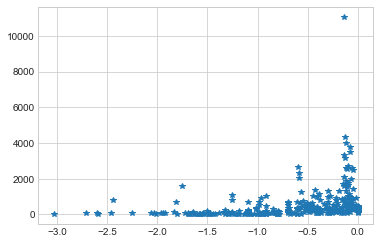

In [34]:
plt.plot(np.log(dist2), dist1, '*')

In [35]:
len(dist1)

332

In [36]:
for i, f1_val in f1_by_instance['wat'].items():
    if i in instance_frequencies.keys():
        print(i, instance_frequencies[i], f1_val)
    else:
        print(i, ':-(')

Balochistan,_Pakistan 1 1.0
Bledar_Kola 1 1.0
Sydney_Cricket_Ground 1 0.0
Michael_Marsh_(athlete) 1 1.0
Burundi_national_football_team 5 0.0
KBC_Bank 1 1.0
Tirana 14 0.6666666666666666
Pembroke_Pines,_Florida 2 1.0
Giovanni_Goria 2 1.0
Darren_Eadie 1 1.0
FC_Chornomorets_Odesa 2 0.0
Louis_Freeh 1 1.0
Sheffield_United_F.C. 9 0.9411764705882353
Denver_International_Airport 1 1.0
Environment_and_Climate_Change_Canada 1 1.0
Andy_Benes 2 1.0
Stansted_Mountfitchet 1 0.0
Maurice_Baril 4 1.0
Marcelo_Filippini 2 1.0
Yamaha_Motor_Company 12 0.15384615384615385
Debbie_Graham 2 1.0
Sale_Grammar_School 1 1.0
Sindh_High_Court 1 0.0
Andre_Snyman 2 1.0
Western_State_(Nigeria) :-(
Carsten_Ramelow 1 1.0
Melbourne_Football_Club 4 0.0
National_Institute_for_Health_and_Care_Excellence :-(
Evercore_Partners 1 1.0
Cuba 34 0.9393939393939394
Robert_Schuman 1 1.0
Tim_Stimpson 2 1.0
Bryan_Herta 1 1.0
Tignes 5 1.0
Eta_(disambiguation) 9 0.0
Budapesti_VSC 2 0.0
Paul_Curry_(golfer) 1 1.0
Communist_Party_of_China 2 

Anders_Forsbrand 3 1.0
Alex._Brown_&_Sons 2 0.0
Crédit_Agricole_(cycling_team) 1 1.0
Andrew_Flintoff :-(
Roseburg,_Oregon 1 1.0
Daryll_Cullinan 1 1.0
Labour_Day 3 0.0
Reuter 11 0.0
Claude_Makélélé 1 1.0
Carlos_Calado 1 1.0
Marcelo_Ríos 15 0.9655172413793104
Johnny_Pesky 1 1.0
Thomas_Enqvist 10 0.6666666666666666
Keirin 1 0.0
Tarmac_(company) 1 1.0
FC_Torpedo_Moscow 3 0.0
Lars_Riedel 2 1.0
Marshall_University 3 0.6666666666666666
Edward_Dmytryk 1 1.0
Likud 3 1.0
Supreme_Court_of_the_Republic_of_China 1 0.0
Erik_Hanson_(baseball) :-(
Japan_Airlines 1 1.0
FC_Krylia_Sovetov_Samara 2 1.0
East_Timor 5 0.7499999999999999
Seville 1 1.0
Nelson_Mandela 4 1.0
Amstetten,_Lower_Austria 1 1.0
Ewald_Brenner 1 1.0
Susi_Susanti 3 1.0
Cambridge,_Massachusetts 1 1.0
Paolo_Vaccari 1 1.0
Baltimore_Ravens 2 0.0
Nouakchott 3 0.5
Zahoor_Elahi 1 1.0
Wellington 19 0.8484848484848484
CONCACAF_Champions_League 1 0.0
La_Nación 1 1.0
Jorge_Cadete 2 1.0
George_Hincapie 3 1.0
Magdalena_Maleeva 8 0.7692307692307693
Fr

Zvornik 4 1.0
UCI_Road_World_Cup 5 0.5714285714285715
Viktor_Chernomyrdin 8 1.0
Granma_(newspaper) 2 0.0
Howard_Wolpe 1 1.0
Fung_Permadi 3 1.0
Necmettin_Erbakan 6 1.0
2008_Alpine_Skiing_World_Cup :-(
Al-Karak 4 1.0
Gold_Coast_Chargers 1 0.0
Derek_Mills 2 1.0
Bogotá 10 0.9473684210526316
DFB-Pokal 2 0.0
Béla_Markó 1 1.0
Darryn_Hill 2 1.0
Akhbar 1 0.0
German_Open_(golf) 7 0.25
Minnesota 9 0.6
FC_St._Pauli 16 0.5454545454545454
S.S.D._Parma_Calcio_1913 10 0.8235294117647058
Fernando_Couto 2 1.0
Pavel_Polomský 1 1.0
Raymond_James_Financial 1 1.0
Scott_Sanders_(baseball) 1 1.0
Philippine_Basketball_Association 3 0.0
First_Pacific 1 1.0
Oklahoma 5 0.5714285714285715
Colombo 27 0.5789473684210525
E._F._Hutton_&_Co. 1 1.0
PSV_Eindhoven 33 0.625
Grant_Flower 1 0.6666666666666666
Belfast 5 0.7499999999999999
Dănuț_Lupu 4 1.0
Tom_Pukstys 2 1.0
Juan_González_(baseball) 1 1.0
Sammy_Sosa 6 0.9090909090909091
Marvin_Harrison 1 1.0
Johan_Museeuw 4 0.6666666666666666
York_Racecourse :-(
Ferrari 2 0.0
C

Frederick_Chiluba 2 1.0
Gillingham_F.C. 8 0.2222222222222222
Marcos_Ondruska 2 1.0
Bobby_Robson 3 0.8
2000_Summer_Olympics 3 0.0
Craig_Brown 2 0.0
Juha_Kankkunen 8 0.9333333333333333
FK_Drnovice 2 0.0
Hanover 3 0.7499999999999999
International_Paper 1 1.0
Hintsa_kaKhawuta 3 0.8
Nashville,_Tennessee 1 1.0
Kolkata 14 0.923076923076923
Ville_Peltonen 1 0.0
Nobel_Peace_Prize 10 0.18181818181818182
South_Island 2 0.6666666666666666
Roberto_Chiappa 1 1.0
Panathinaikos_F.C. 1 1.0
Arkansas_State_Police 1 0.0
Samuel_Matete 2 1.0
Al_Ain_FC :-(
Bury_F.C. 7 0.0
Frankfurt 9 0.631578947368421
Scott_Young_(Welsh_footballer) :-(
Frankie_Fredericks 8 1.0
Tim_Munton 1 1.0
First_Chicago_Bank 1 1.0
David_Carter_(golfer) 4 1.0
KinderCare_Learning_Centers 1 1.0
Winnipeg 5 0.888888888888889
Luton_Town_F.C. 8 0.4
Ipsos 1 1.0
Vaduz 1 0.0
Lagos 5 0.33333333333333337
FK_Dukla_Banská_Bystrica 2 0.6666666666666666
Rose_Bowl_(stadium) 1 0.0
Bristol_City_F.C. 9 0.8750000000000001
Bombay_Stock_Exchange :-(
Stuart_McC

John_Jaha 2 1.0
Paris 61 0.6521739130434782
Prudential_plc 1 1.0
ASEC_Mimosas 1 1.0
British_Airways 8 1.0
Tom_Moody 6 0.8
Damon_Hill 5 1.0
Rangers_F.C. 11 0.7058823529411764
Édouard_Balladur 1 1.0
Hendro_Kartiko 2 1.0
Appalachian_Trail_Conservancy 1 0.0
Jimmy_Vasser 1 1.0
Charleston_Gazette-Mail 1 0.0
Thomas_Bjørn 3 1.0
Pudong 1 0.0
Kamiel_Maase 1 1.0
Republican_Party_(United_States) 46 0.9176470588235294
Ministry_of_Foreign_Affairs_(Israel) 1 0.0
Edwin_Vurens 1 0.0
Commonwealth_of_Nations 13 0.9230769230769231
Sérgio_Conceição 1 1.0
Liberia 12 0.8799999999999999
AOL 6 1.0
Panhellenic_Socialist_Movement 1 1.0
Sun_Jun_(badminton) 3 0.0
Twyford_Down 2 1.0
Paul_Strang 1 1.0
Justin_Hobday 2 1.0
Currie_RFC 1 0.0
Amsterdam 48 0.775
FIFA 13 0.9600000000000001
Omaha,_Nebraska 2 0.6666666666666666
FIFPro :-(
Terry_Pendleton 1 1.0
Jennifer_Aniston 1 1.0
Florida_Panthers 3 0.0
Ayr_United_F.C. 5 0.0
Jakob_Hlasek 2 1.0
Luxembourg_Stock_Exchange 1 0.0
Vladimir_Dubrovshchik 2 1.0
Mountain_View,_Calif

Czech_Republic 87 0.8695652173913044
Costantino_Rocca 8 1.0
Magnus_Larsson 1 1.0
Scotland_national_under-21_football_team 1 0.0
Royal_Boskalis_Westminster 2 0.6666666666666666
List_of_national_stadiums 1 0.0
James_Love 1 0.0
Albert_Ferrer 2 1.0
Akira_Ryō 1 1.0
Eneco_Tour 1 0.0
Randy_Johnson 2 1.0
Olga_Slyusareva 1 1.0
FC_Spartak_Moscow 2 0.6666666666666666
JS_Massira 1 1.0
Espinho,_Portugal :-(
Pat_Hurst 1 1.0
Mario_Stanić 1 1.0
Maariv_(newspaper) 1 0.0
Chad_Curtis 2 1.0
Esporte_Clube_Juventude 4 0.4
Hamas 7 0.923076923076923
Chile 31 0.90625
Luís_Oliveira 3 1.0
Andrea_Hlaváčková 1 1.0
Kilmarnock_F.C. 6 0.2857142857142857
Paul_McGrath_(footballer) 2 1.0
MLB_Network 1 0.0
Lorenzo_Amoruso 1 1.0
Carole_Montillet 6 1.0
Zadar 3 1.0
Hapoel_Jerusalem_F.C. 3 0.8
National_Hurricane_Center 1 0.0
University_of_Michigan 1 0.0
Finland_men's_national_ice_hockey_team 4 0.0
Garrett_Hines 2 1.0
Nicoleta_Grasu 1 1.0
Paul_Affleck 1 1.0
Sidya_Touré 1 1.0
Philadelphia_76ers 3 0.0
Marco_Bode 2 0.66666666666

Benazir_Bhutto 8 1.0
Edison_(company) :-(
Cal_Eldred 1 1.0
Fred_McGriff 3 1.0
Saracens_F.C. 3 0.8
Barclays 2 1.0
Sky_(United_Kingdom) 2 1.0
Ciriaco_Sforza 1 1.0
Hungary 36 0.9411764705882353
Shahid_Afridi 4 0.4
Long_Island 2 0.8
Shannon,_County_Clare :-(
Dodge_City,_Kansas 2 0.0
Harold_Baines 2 1.0
Roger_Chapman_(golfer) 4 1.0
Tarek_Jabban 1 1.0
Almere 5 1.0
Carlo_Ancelotti 1 1.0
ABN_AMRO 1 1.0
International_Petroleum_Exchange 3 0.8
Eberhard_Carl 1 0.0
Welsh,_Carson,_Anderson_&_Stowe 1 1.0
Crystal_Palace_F.C. 10 0.8235294117647058
Adriatic_Sea 1 0.0
Federal_Communications_Commission 2 1.0
Honduras 5 0.888888888888889
Jeddah 1 0.0
John_Veldman 5 1.0
Jean_Alesi 5 1.0
The_Sunday_Telegraph 1 1.0
Nick_Price 2 1.0
Constand_Viljoen 5 1.0
Kenny_Benjamin 1 1.0
Government_of_the_United_Kingdom 1 0.0
FK_Proleter_Zrenjanin 2 0.0
Krzysztof_Piskuła 1 1.0
LA_Women's_Tennis_Championships :-(
Adrian_Ilie 1 1.0
Colin_Calderwood 1 1.0
FK_Budućnost_Podgorica 3 0.0
John_Crawley 4 0.8571428571428571
Superco

Elf_(film) :-(
A.F.C._Bournemouth 7 0.0
Rheinpark_Stadion 1 0.0
Berlin 32 0.7450980392156863
Hanson_plc 2 1.0
Gillian_Russell 2 1.0
Chihuahua_(state) :-(
Canberra_Raiders 4 0.0
BellSouth 1 1.0
CBS_Corporation 1 0.0
Jeff_Russell 1 1.0
Tim_Henman 6 1.0
Ilke_Wyludda 1 1.0
1996_Summer_Olympics 28 0.1875
Karachi_Stock_Exchange 4 0.8571428571428571
Boomer_Esiason 2 0.6666666666666666
U.C._Sampdoria 4 0.8571428571428571
Boland,_Western_Cape :-(
Cleveland_Indians 43 0.42857142857142855
Tegla_Loroupe 1 1.0
Viktor_Paço 1 1.0
Luxembourg 6 0.7272727272727272
Davor_Šuker 4 1.0
Volkswagen_Passat 1 0.0
Don_Wengert 2 1.0
Matthias_Hagner 1 0.0
Ken_Green_(golfer) 1 1.0
Mumbai 13 0.7000000000000001
Doncaster_Cup 1 0.0
Matt_Lawton 2 1.0
Gunn_Margit_Andreassen 1 1.0
Prague 11 0.7777777777777778
Venezuela 21 0.9500000000000001
Ballybunion 5 0.888888888888889
Václav_Havel 15 1.0
Mongolia 3 1.0
Biathlon_World_Cup 3 0.0
The_Jordan_Times 1 0.0
Carroll_College_(Montana) 1 1.0
Arabs 9 0.5454545454545455
Agent_Ora

Greenwich_Mean_Time 64 0.2222222222222222
Hall_of_fame 3 0.0
Francisco_Clavet 3 1.0
Alexia_Dechaume-Balleret 1 1.0
Jesper_Skibby 2 0.6666666666666666
Estonia 14 0.8148148148148148
Alan_McLoughlin 2 1.0
Durrës 1 1.0
Kecskemét 1 1.0
China_national_football_team 5 0.0
East_Stirlingshire_F.C. 6 0.0
Costain_Group 2 1.0
Olympiacos_F.C. 2 0.0
Pohang :-(
Chryste_Gaines 2 1.0
World_Series 1 0.0
Tony_Eusebio 1 1.0
Arthur_Numan 2 1.0
Lanarkshire 1 1.0
Queen's_Park,_Chesterfield 1 0.0
Élie_Baup 1 1.0
Ieng_Sary 4 1.0
Club_Atlético_Platense 1 0.0
Raytheon 1 1.0
Craig_Quinnell 1 1.0
Rusty_Greer 5 0.888888888888889
West_Michigan_Grand_Prix :-(
Israel_Broadcasting_Authority :-(
Jumet 1 1.0
Salomon_Brothers 5 0.7499999999999999
Torquay_United_F.C. 7 0.0
American_Airlines 3 1.0
Billie_Jean_King 7 1.0
Division_of_Fraser :-(
McLaren 8 0.4
Liberia,_Costa_Rica :-(
Madrid 19 0.6428571428571429
R._J._Reynolds_Tobacco_Company :-(
Israel 194 0.9818181818181818
Kimberly_Po 4 1.0
Arantxa_Sánchez_Vicario 11 0.95652

Torrance_Zellner 2 1.0
Colchester 3 0.5714285714285715
Mike_Stanley 1 1.0
Alan_Kernaghan 1 1.0
Cheah_Soon_Kit 1 0.0
Helsinki 8 0.2222222222222222
Petr_Korda 8 1.0
Russia_national_football_team 4 0.0
Chelsea_F.C. 15 0.7499999999999999
Superman_(disambiguation) 2 0.0
ZAKSA_Kędzierzyn-Koźle :-(
Emmanuel_Tetteh 1 1.0
Jacob_Brumfield 1 1.0
Southeast_Asia 1 1.0


### 6) Entropy

<span style="background-color:lightgreen">Section 6.3. of the paper</span>


**6.1. Plot F1-scores per entropy class**

In [58]:
forms_per_rentropy=defaultdict(set)
for form, entr in form_entropies.items():
    rounded_entropy=round(entr,1)
    forms_per_rentropy[rounded_entropy].add(form)

In [83]:
totals=analysis_utils.get_freq_totals(system_articles[systems[0]],
                                      set(),
                                      ambiguous_only=False
                                     )

AGDISTIS
SPOTLIGHT
WAT


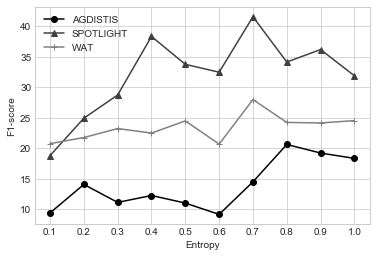

In [85]:

fig = plt.figure()
cnt=0
c=['o', '^', '+', '3', 'x']
clr=['0.0', '0.25', '0.5', '0.7', '0.8']


for system in systems:
    w=open('debug/entropy_%s.tsv' % system, 'w')
    w.write('ENTROPY\tFREQUENCY\tF1\tFORM\tINSTANCE\n')
    xs=[]
    ys=[]
    print(system.upper())
    for rentropy, forms_set in sorted(forms_per_rentropy.items()):
        prf=compute_macro_prf_on_selection(p[system], r[system], f1[system], forms_set)
        f1_sub=prf[2]
        for frm in sorted(list(forms_set)):
            interps=interpretations[frm]
            for i in interps:
                t=(frm, i)
                a='N/A'
                frq='N/A'
                if t in f1[system]:
                    a=f1[system][t]
                if frm in totals and i in totals[frm]:
                    frq=totals[frm][i]
                w.write('%f\t%s\t%f\t%s\t%s\n' % (round(rentropy,1), frq, a, frm, i))
                    
        w.write('\n')
        xs.append(rentropy)
        ys.append(f1_sub*100.0)
    plt.plot(xs, ys, "%s-" % c[cnt], color=clr[cnt], label=system.upper())
    cnt+=1
    w.close()
plt.legend()
plt.xlabel('Entropy')
plt.ylabel('F1-score')
plt.xticks(xs)
 
plt.show()

save=True
if save:
    fig.savefig('img/macro_entropy_f1.png')


**6.2. Compute correlation between form entropy and P/R/F1**

In [66]:
for metric in [prec_by_form, recall_by_form, f1_by_form]:
    for system in systems:
        print(system.upper())
    
        dist1, dist2 = analysis_utils.prepare_lists(metric[system], form_entropies)
        correlation, significance = spearmanr(dist1, dist2)
        print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)

AGDISTIS
The Spearman correlation between X and Y is: 0.022515258421882824 . Significance:  0.6126585370925886
SPOTLIGHT
The Spearman correlation between X and Y is: -0.109360199312578 . Significance:  0.013656172876266527
WAT
The Spearman correlation between X and Y is: -0.09910142231899081 . Significance:  0.02550735470639067
AGDISTIS
The Spearman correlation between X and Y is: 0.14822852299093367 . Significance:  0.0008046172863287482
SPOTLIGHT
The Spearman correlation between X and Y is: 0.014931746636811138 . Significance:  0.7370713551405891
WAT
The Spearman correlation between X and Y is: 0.02955449919112908 . Significance:  0.5062879242181675
AGDISTIS
The Spearman correlation between X and Y is: 0.13920235393902503 . Significance:  0.001660538789754314
SPOTLIGHT
The Spearman correlation between X and Y is: -0.028732285317016958 . Significance:  0.5181945625566886
WAT
The Spearman correlation between X and Y is: -0.021289377675573533 . Significance:  0.6321446527659016


### 7) Correlation between instance ranks (of a form) and performance

<span style="background-color:lightgreen">Section 6.4. of the paper</span>


**7.1. Collect interpretations for a form**


In [67]:
interpretations=defaultdict(set)
for article in system_articles['spotlight']:
    for mention in article.entity_mentions:
        form=mention.mention
        meaning=mention.gold_link
        if not skip_nils or meaning!='--NME--':
            interpretations[form].add(meaning)

In [68]:
interpretations['Marseille']

{'Marseille', 'Olympique_de_Marseille'}

**7.2. Aggregate per rank**

In [73]:
def evaluate_ranks_macro(p, r, f1, rank_tuples):
    p_rank=defaultdict(list)
    r_rank=defaultdict(list)
    f1_rank=defaultdict(list)
    
    p_rank_avg={}
    r_rank_avg={}
    f1_rank_avg={}
    
    for rank, r_tuples in rank_tuples.items():
        for t in r_tuples:
            p_rank[rank].append(p[t])
            r_rank[rank].append(r[t])
            f1_rank[rank].append(f1[t])
    
    for rank in range(1,13):
        p_rank_avg[rank]=np.mean(p_rank[rank])
        r_rank_avg[rank]=np.mean(r_rank[rank])
        f1_rank_avg[rank]=np.mean(f1_rank[rank])
        
    return p_rank_avg, r_rank_avg, f1_rank_avg

In [74]:
def macro_rank_analysis(systems, system_articles, ambiguous_forms, uri_pr=None, ambiguous_only=True, factor='freq'):

    print(factor)
    fig, axs = plt.subplots(1,3, sharey=True, figsize=(14,3))
    p_rank={}
    r_rank={}
    f1_rank={}

    for system in systems:
        w=open('debug/%srank_%s.tsv' % (factor, system), 'w')
        rank_tuples=analysis_utils.prepare_ranks(system_articles[system], 
                                                  ambiguous_forms,
                                                  uri_pr=uri_pr,
                                                  ambiguous_only=ambiguous_only, 
                                                  factor=factor)
        for rank in sorted(rank_tuples.keys()):
            w.write('%d\n' % rank)
            for t in rank_tuples[rank]:
                w.write(' \t%s\t%s\n' % (t[0], t[1]))
            w.write('\n')
        w.close()
        #print(rank_tuples)
        p_rank[system], r_rank[system], f1_rank[system] = evaluate_ranks_macro(p[system], r[system], f1[system], 
                                                          rank_tuples)
        
        print()

    plot_utils.plot_prf(p_rank, systems, axs[0], title="PRECISION")
    plot_utils.plot_prf(r_rank, systems, axs[1], title="RECALL")
    plot_utils.plot_prf(f1_rank, systems, axs[2], title="F1-SCORE")

    plt.show()

    fig.savefig('img/accuracy_per_%s_rank.png' % factor, bbox_inches='tight')

freq



[ 1  2  3  4  5  6  7  8  9 10 11 12]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[ 1  2  3  4  5  6  7  8  9 10 11 12]


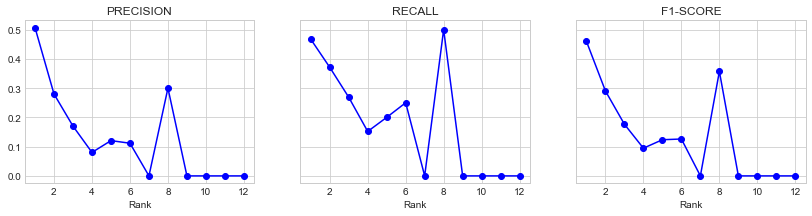

In [75]:
macro_rank_analysis(systems, system_articles, ambiguous_forms, ambiguous_only=True, factor='freq')

#### 7.3 PR ranks


pr



[ 1  2  3  4  5  6  7  8  9 10 11 12]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[ 1  2  3  4  5  6  7  8  9 10 11 12]


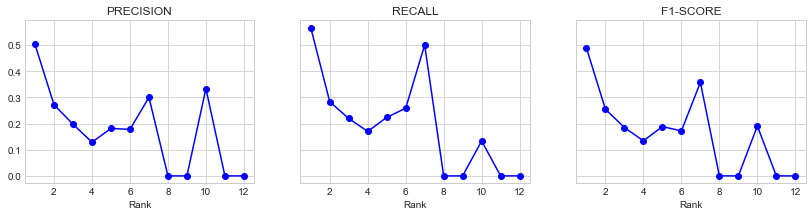

In [78]:
macro_rank_analysis(systems, system_articles, ambiguous_forms, uri_pr=uri_pr, ambiguous_only=True, factor='pr')